In [1]:
import pyNN.nest as p
from pyNN.random import NumpyRNG, RandomDistribution
from pyNN.utility import Timer
import pylab
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

timer = Timer()
ts = 0.1
simulation_time = 100


In [2]:
def setup(simulation_time, ts):


    timer = Timer()
    

    #p.setup(timestep=ts, min_delay=ts, max_delay=2.0*ts) # 0.1ms 
    p.setup(timestep=ts) # 0.1ms



In [157]:
def compute_network_state(n_res, w_exc_b, w_inh_b, rout_w_exc, rout_w_inh, inp_rate):
    n_input_neurons     = 10
    n_readout_neurons   = 2
    n_reservoir_neurons = n_res
    exc_rate            = 0.8 # % of excitatory neurons in reservoir

    n_exc = int(round(n_reservoir_neurons*exc_rate))
    n_inh = n_reservoir_neurons-n_exc
    izh_celltype = p.native_cell_type('izhikevich')
    if_celltype = p.IF_curr_exp
    celltype = if_celltype
    
    spike_source = p.native_cell_type('poisson_generator')
    inp_pop=p.Population(n_input_neurons,spike_source,{'rate':inp_rate, 'start':0.0,'stop':40.0})
    
    #exc_cells = p.Population(n_exc, celltype,cellparams={'tau_refrac':1.}, label="Excitatory_Cells")
    exc_cells = p.Population(n_exc, celltype, label="Excitatory_Cells")
    inh_cells = p.Population(n_inh, celltype, label="Inhibitory_Cells")

    # initialize with a uniform random distributin
    # use seeding for reproducability
    rngseed = 98766987
    parallel_safe = True
    rng = NumpyRNG(seed=rngseed, parallel_safe=parallel_safe)

    unifDistr = RandomDistribution('uniform', (-70,-65), rng=rng)
    inh_cells.initialize('V_m',unifDistr)
    exc_cells.initialize('V_m',unifDistr)
    
    readout_neurons = p.Population(2, celltype, label="readout_neuron")
    
    inp_weight=3.
    inp_delay =1

    inp_weight_distr = RandomDistribution('normal', [inp_weight, 1e-3], rng=rng)

    # connect each input neuron to 30% of the reservoir neurons
    inp_conn = p.FixedProbabilityConnector(p_connect=0.3/np.sqrt(n_res)*np.sqrt(200),weights =inp_weight_distr, delays=inp_delay)

    connections = {}
    connections['inp2e'] = p.Projection(inp_pop, exc_cells, inp_conn)
    connections['inp2i'] = p.Projection(inp_pop, inh_cells, inp_conn)

    pconn = 0.05      # sparse connection probability

    # scale the weights w.r.t. the network to keep it stable
    w_exc = w_exc_b/np.sqrt(n_res)      # nA
    w_inh = w_inh_b/np.sqrt(n_res)   # nA
    
    # without weight scaling
    #w_exc = w_exc_b/np.sqrt(200)      # nA
    #w_inh = w_inh_b/np.sqrt(200)  # nA
    
    delay_exc = 1      # defines how long (ms) the synapse takes for transmission
    delay_inh = 1

    weight_distr_exc = RandomDistribution('normal', [w_exc, 1/n_res], rng=rng)
    weight_distr_inh = RandomDistribution('normal', [w_inh, 1/n_res], rng=rng)
    exc_conn = p.FixedProbabilityConnector(pconn, weights=weight_distr_exc, delays=delay_exc)
    inh_conn = p.FixedProbabilityConnector(pconn, weights=weight_distr_inh, delays=delay_inh)

    connections['e2e'] = p.Projection(exc_cells, exc_cells, exc_conn, target='excitatory')
    connections['e2i'] = p.Projection(exc_cells, inh_cells, exc_conn, target='excitatory')
    connections['i2e'] = p.Projection(inh_cells, exc_cells, inh_conn, target='inhibitory')
    connections['i2i'] = p.Projection(inh_cells, inh_cells, inh_conn, target='inhibitory')
    
    # Eigenvalue analysis for stability
    
    weights_e2e = connections['e2e'].getWeights(format='array')
    weights_e2i = connections['e2i'].getWeights(format='array')
    weights_i2e = connections['i2e'].getWeights(format='array')
    weights_i2i = connections['i2i'].getWeights(format='array')

    a=np.concatenate((weights_e2e,weights_i2e), axis=0)
    b=np.concatenate((weights_e2i,weights_i2i), axis=0)
    weight_matrix=np.concatenate((a,b), axis=1)
    np.nan_to_num(weight_matrix, copy=False)
    eigenvalues, eigenvectors=np.linalg.eig(weight_matrix)
    plt.scatter(eigenvalues.real, eigenvalues.imag)
    '''
    weights_e2e = connections['e2e'].getWeights(format='array')
    np.nan_to_num(weights_e2e, copy=False)
    eigenvalues, eigenvectors=np.linalg.eig(weights_e2e)
    plt.scatter(eigenvalues.real, eigenvalues.imag)
    '''
    
    rout_conn_exc = p.AllToAllConnector(weights=rout_w_exc, delays=delay_exc)
    rout_conn_inh = p.AllToAllConnector(weights=rout_w_inh, delays=delay_exc)

    
    

    connections['e2rout'] = p.Projection(exc_cells, readout_neurons, rout_conn_exc, target='excitatory')
    connections['i2rout'] = p.Projection(inh_cells, readout_neurons, rout_conn_inh, target='inhibitory')
    
    readout_neurons.record()
    exc_cells.record()
    inh_cells.record()
    inp_pop.record()
    
    
    p.run(simulation_time)

    r_spikes = readout_neurons.getSpikes()
    exc_spikes = exc_cells.getSpikes()
    inh_spikes = inh_cells.getSpikes()
    inp_spikes = inp_pop.getSpikes()

    #p.end()
    
    return r_spikes, exc_spikes, inh_spikes, inp_spikes

In [158]:
def plot_spikes(spiketrain):
    st = [spike[1] for spike in spiketrain] # spike times
    sid = [spike[0] for spike in spiketrain]

    plt.plot(st, sid, "|")
    plt.axis([np.min(st), 100, np.min(sid)-1, np.max(sid)+1])
    plt.xlabel('Time (ms)')
    plt.ylabel('Neuron ID')
    plt.title('Spike Plot')
    plt.xlim(xmin=0)
    plt.show()

# Define and Run Network

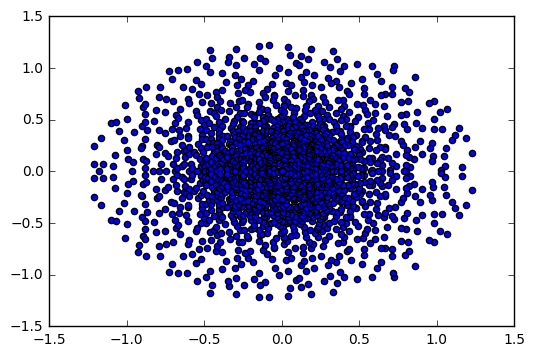

In [159]:
n_res=2000
w_exc_b=2.828
w_inh_b=-11.312
rout_w_exc=20
rout_w_inh=-80
inp_rate=100.0

ts = 0.1
simulation_time = 100

setup(simulation_time,ts)
r_spikes, exc_spikes, inh_spikes, inp_spikes = compute_network_state(n_res, w_exc_b, w_inh_b, rout_w_exc, rout_w_inh, inp_rate)


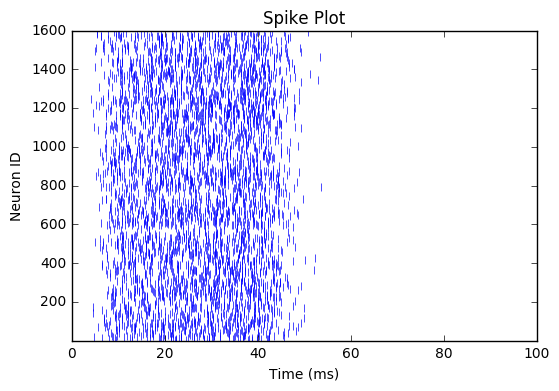

In [160]:
plot_spikes(exc_spikes)

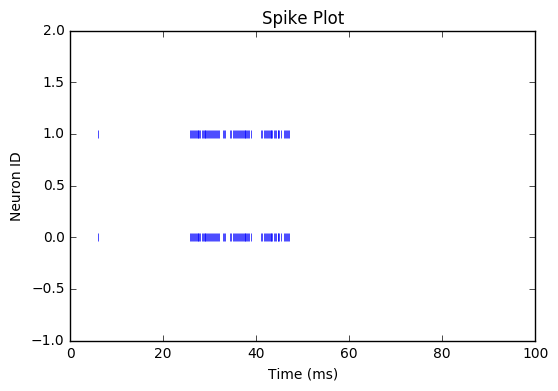

In [133]:
plot_spikes(r_spikes)

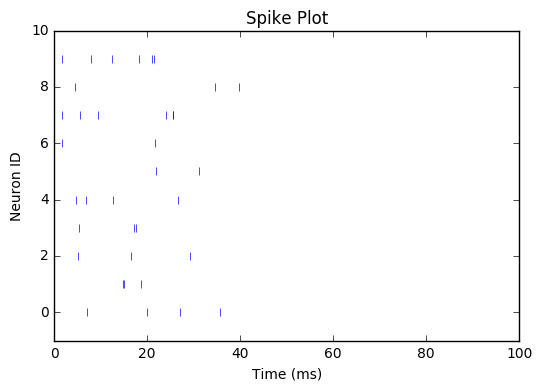

In [134]:
plot_spikes(inp_spikes)

In [ ]:
st = [spike[1] for spike in r_spikes]
st[:10]


In [ ]:
r_spikes[:10]

In [ ]:
np.shape(r_spikes)

In [ ]:
np.shape(exc_spikes)

In [ ]:
def get_spike_rates(spikes):
    """returns the rates of all neurons in the recorded population"""
    shape=np.shape(spikes)
    spike_rates=np.zeros((int(np.max(spikes[:,0]))+1,))
    for i in range(shape[0]): # for each spikes
        for j in range(int(np.max(spikes[:,0]))+1): #for each neuron
            if spikes[i,0]==j:
                spike_rates[j]+=1
    return spike_rates

In [ ]:
spike_rates=get_spike_rates(r_spikes)
spike_rates

In [ ]:
res_rates=get_spike_rates(exc_spikes)
res_rates

In [ ]:
# separability: different input signals (1. rates, 2. time series of rates)
# must lead to different reservoir state vectors
# needs a distance metric

In [ ]:
n_res=200
w_exc_b=2
w_inh_b=-8
rout_w_exc=20
rout_w_inh=-80
inp_rate=20.0

r_spikes2, exc_spikes2 = compute_network_state(n_res, w_exc_b, w_inh_b, rout_w_exc, rout_w_inh, inp_rate)


In [ ]:
# todo: kernel stops when rerunning compute_network_state
